In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import shutil
import opendatasets as od
from sklearn.preprocessing import LabelEncoder
pd.set_option('mode.chained_assignment', None)
from tqdm import tqdm
import pysnooper

In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../'))
subdir = 'utils'
path = os.path.join(parent_dir, subdir)
sys.path.append(path)
from tqdm import tqdm

In [4]:
# Get the data from here https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data
path_to_directory = os.path.abspath('../data/titanic')
if not os.path.exists(path_to_directory):
    # URL of the dataset
    dataset_url = 'https://www.kaggle.com/competitions/titanic/data'
    # Download the dataset to the specified location
    od.download(dataset_url)
    shutil.move(os.path.abspath('titanic'), path_to_directory)

train_data = 'train.csv'
test_data = 'test.csv'
train_df = pd.read_csv(os.path.join(path_to_directory, train_data))
test_df = pd.read_csv(os.path.join(path_to_directory, test_data))

In [5]:
train_df = train_df.fillna(0)

In [6]:
import matplotlib.pyplot as plt
plt.style.use(['ipynb'])

In [7]:
@pysnooper.snoop()
def create_something(iter):
    x = 0
    for i in range(iter):
        x = x+i**34

In [8]:
create_something(10)

Source path:... /tmp/ipykernel_676151/3894628613.py
Starting var:.. iter = 10
13:06:22.018450 call         1 SOURCE IS UNAVAILABLE
13:06:22.018651 line         3 SOURCE IS UNAVAILABLE
New var:....... x = 0
13:06:22.018669 line         4 SOURCE IS UNAVAILABLE
New var:....... i = 0
13:06:22.018688 line         5 SOURCE IS UNAVAILABLE
13:06:22.018705 line         4 SOURCE IS UNAVAILABLE
Modified var:.. i = 1
13:06:22.018721 line         5 SOURCE IS UNAVAILABLE
Modified var:.. x = 1
13:06:22.018735 line         4 SOURCE IS UNAVAILABLE
Modified var:.. i = 2
13:06:22.018749 line         5 SOURCE IS UNAVAILABLE
Modified var:.. x = 17179869185
13:06:22.018763 line         4 SOURCE IS UNAVAILABLE
Modified var:.. i = 3
13:06:22.018776 line         5 SOURCE IS UNAVAILABLE
Modified var:.. x = 16677198879535754
13:06:22.018789 line         4 SOURCE IS UNAVAILABLE
Modified var:.. i = 4
13:06:22.018801 line         5 SOURCE IS UNAVAILABLE
Modified var:.. x = 295164582378232361610
13:06:22.018825 line

# Decision Treest

Recursive partitioning. Regularisation reduce the depth of the tree.

Advantages:
- white box models

Disadvantages:

In [9]:
# Decision trees

class Decision_tree():
    def __init__(self, data, target, max_depth) -> None:
        self.data = data
        self.target = target
        self.seen = set()
        self.max_depth = max_depth
        
    def all_iteration(self):
        while self.max_depth >0:
            self.best_split_for_single_iter()
            print(self.seen)
            self.max_depth -= 1 
        return self.gini_values
    
    def best_split_for_single_iter(self):
        columns = [col for col in self.data.columns if col not in ['PassengerId', self.target, 'Name', 'Ticket'] ]
        self.gini_values = {}
        for col  in columns:
            for val in self.data[col].unique():
                if (col, str(val)) not in self.seen:
                    gini_weighted = self.split(col, val)
                    self.gini_values[col + '_split_' + str(val)] = gini_weighted
                else:
                    print('dont calculate gini on these', col, val)
                    
        # Find the minimum value of the dictionary and update the self.data
        min_key = min(self.gini_values, key=self.gini_values.get)
        col, val = min_key.split('_split_')
        print(col, val)
        self.seen.add((col, str(val)))
        return (col, val)
        
            
    def split(self, col, val):
        
        # Calculate probability for each node
        cls1 = self.data[self.data[col] == val]
        cls2 = self.data[self.data[col] != val]
        prob_list, n1, n2 = self.calculate_probability(cls1, cls2)
        
        # Calculate gini_index for each node
        g1, g2 = self.gini_index(prob_list)
        
        # Return weighted gini-impuritiny index
        return self.gini_impurity_for_split(g1, g2, n1, n2)
    
    def calculate_probability(self, cls1, cls2):
        ''''''
        prob_cls1 = []
        prob_cls2 = []
        n1 = len(cls1)
        n2 = len(cls2)
        for val in cls1[self.target].unique():
            temp_data = len(cls1[cls1[self.target] == val].copy(deep=True))
            prob_cls1.append(temp_data / n1)

        for val in cls2[self.target].unique():
            value2 = len(cls2[cls2[self.target] == val].copy(deep=True))
            prob_cls2.append(value2 / n2)
        return [prob_cls1, prob_cls2], n1, n2
        
    def gini_index(self, prob_list):
        g1 =  1 - np.sum([element **2 for element in prob_list[0]])
        g2 =  1 - np.sum([element **2 for element in prob_list[1]])
        return g1, g2
        
    def gini_impurity_for_split(self, g1, g2, n1, n2):
        return n1/(n1+n2) * g1 + n2/(n1+n2) * g2
        

In [14]:
decision_tree = Decision_tree(train_df, 'Survived', 5)
gini_dict = decision_tree.all_iteration()

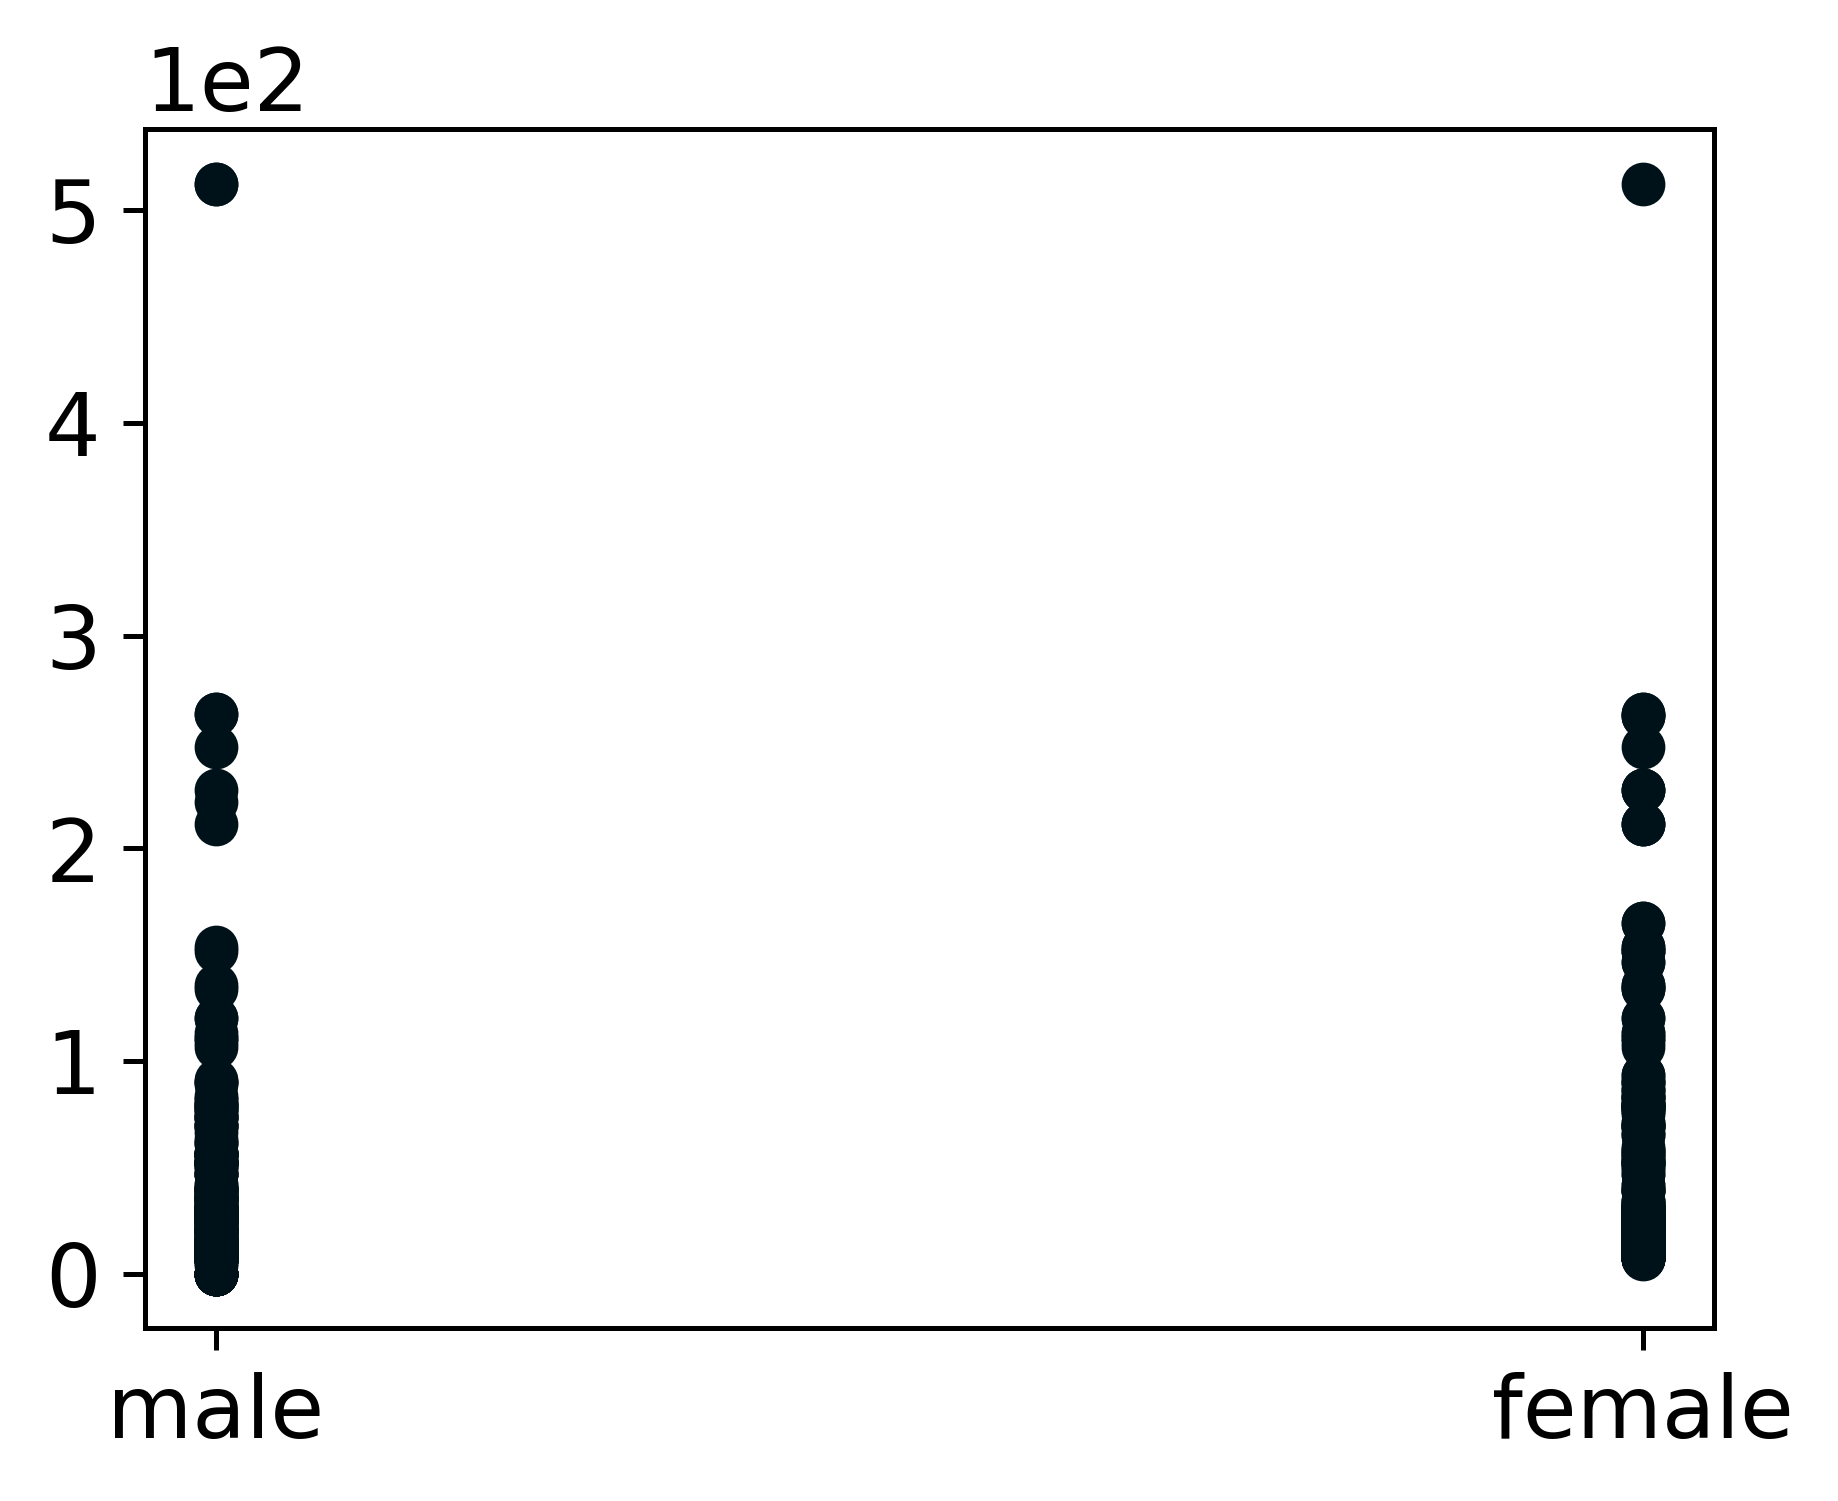

In [11]:
# pd.options.plotting.backend = 'plotly'
plt.scatter(train_df['Sex'], train_df['Fare'])
# plt.scatter(train_df['Survived'], train_df['Sex'])

In [12]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,0,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,0.0,1,2,W./C. 6607,23.4500,0,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [13]:
import seaborn as sns
cmap = sns.light_palette('red', as_cmap =  True)

train_df.style.background_gradient(cmap)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,0,S
5,6,0,3,"Moran, Mr. James",male,0.000000,0,0,330877,8.458300,0,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.862500,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.075000,0,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.133300,0,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.070800,0,C
